# HUMAN ACTIONS CLASSIFIER
---

In [1]:
import os, sys
from pathlib import Path
from tempfile import TemporaryDirectory
import time

In [2]:
os.chdir('video_stream')

In [3]:
import utils.visualizer as vz

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.models import resnet152, ResNet152_Weights

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:
!nvidia-smi

Wed Jul  3 09:20:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off |   00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8              9W /  285W |      51MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
# Initialize the Weight Transforms
weights = ResNet152_Weights.DEFAULT
model = resnet152(weights=weights)
data_transform = weights.transforms()

## Load Data

In [8]:
# !find data/ -name *_checkpoints | xargs rm -r

In [9]:
data_transform = transforms.Compose([
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
from datasets import load_dataset

In [11]:
dataset = load_dataset("Bingsu/Human_Action_Recognition")['train']

In [12]:
from utils.image_ds import TransformDataset as TFDS

In [13]:
ds = TFDS(dataset, data_transform)

In [14]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Split the dataset into train and test sets
train_indices, val_indices = train_test_split(list(range(len(ds))), test_size=0.15, random_state=357, shuffle=True, stratify=list(ds.dataset['labels']))

# Create the train and test subsets
train_dataset = Subset(ds, train_indices)
val_dataset = Subset(ds, val_indices)

# Create the train and val dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, generator=torch.Generator().manual_seed(159))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4, generator=torch.Generator().manual_seed(159))

dataloaders = {'train': train_dataloader} | {'val': val_dataloader}

In [15]:
dataset_sizes = {'train': len(train_indices), 'val': len(val_indices)}

In [16]:
dataset_sizes

{'train': 10710, 'val': 1890}

In [17]:
class_names = {
    0: 'calling',
    1: 'clapping',
    2: 'cycling',
    3: 'dancing',
    4: 'drinking',
    5: 'eating',
    6: 'fighting',
    7: 'hugging',
    8: 'laughing',
    9: 'listening_to_music',
    10: 'running',
    11: 'sitting',
    12: 'sleeping',
    13: 'texting',
    14: 'using_laptop'
}

## Visualize a few images

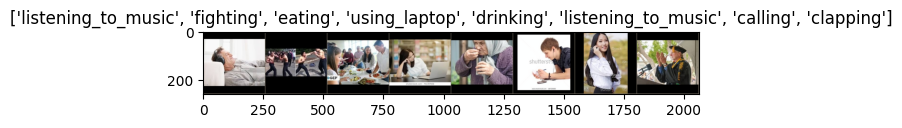

In [18]:
# Get a batch of training data
inputs, classes = next(iter(val_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

vz.imshow(out, title=([class_names[x] for x in classes.tolist()]))

## LEARNING

### Build the model

In [20]:
model_ft = model 
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_conv = model
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_conv = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=32):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler_conv, num_epochs=16)

Epoch 0/15
----------
train Loss: 1.5688 Acc: 0.5719
val Loss: 1.1483 Acc: 0.6698

Epoch 1/15
----------
train Loss: 1.0092 Acc: 0.7075
val Loss: 0.9811 Acc: 0.7063

Epoch 2/15
----------
train Loss: 0.8707 Acc: 0.7442
val Loss: 0.9293 Acc: 0.7169

Epoch 3/15
----------
train Loss: 0.7777 Acc: 0.7683
val Loss: 0.8875 Acc: 0.7333

Epoch 4/15
----------
train Loss: 0.7168 Acc: 0.7877
val Loss: 0.8743 Acc: 0.7302

Epoch 5/15
----------
train Loss: 0.6711 Acc: 0.7994
val Loss: 0.8525 Acc: 0.7392

Epoch 6/15
----------
train Loss: 0.6314 Acc: 0.8114
val Loss: 0.8450 Acc: 0.7317

Epoch 7/15
----------
train Loss: 0.5764 Acc: 0.8343
val Loss: 0.8356 Acc: 0.7407

Epoch 8/15
----------
train Loss: 0.5745 Acc: 0.8384
val Loss: 0.8365 Acc: 0.7386

Epoch 9/15
----------
train Loss: 0.5699 Acc: 0.8379
val Loss: 0.8429 Acc: 0.7381

Epoch 10/15
----------
train Loss: 0.5694 Acc: 0.8373
val Loss: 0.8273 Acc: 0.7471

Epoch 11/15
----------
train Loss: 0.5603 Acc: 0.8428
val Loss: 0.8289 Acc: 0.7429

Ep

## Visualize the model predictions

In [25]:
%run utils/visualizer.py # in case I changed the module `visualizer`

tensor([[ -2.5011,  -1.2041, -12.1871,  -6.9253,  -4.0280,  -2.4307,  -4.9715,
          -6.4897,  -5.9723,  -5.9107,  -9.6433,  -3.9354,  -3.9225,  -4.0363,
          -6.5124],
        [ -4.0009,  -1.3921,  -2.3912,  -2.7416,  -6.8549,  -5.0435,  -2.2937,
          -3.9170,  -7.4590,  -4.3530,  -0.1727,  -0.9379,  -4.3828,  -3.3949,
          -3.5153],
        [ -1.9185,  -3.8008, -11.1335,  -4.8537,   3.7322,  -2.3938,  -2.8008,
          -5.1545,  -3.8921,  -4.4729,  -6.9151,  -7.3851,  -7.8371,  -3.7520,
          -6.4878],
        [ -6.8896,  -2.7552,  -6.2390,   3.5259,  -6.6529,  -5.3331,  -1.8014,
          -6.4758,  -5.8591,  -7.7064,  -3.2737,  -3.9454,  -5.8158,  -5.7478,
          -8.7307],
        [ -5.1743,  -5.3134,   4.1517,  -4.1405,  -5.8266,  -7.3911,  -2.8014,
          -7.1144,  -4.6563,  -5.1056,  -2.0126,  -4.4049,  -5.9100,  -5.6472,
          -5.3412],
        [ -0.4703,  -4.3916,  -8.0041,  -6.5576,  -5.0142,  -0.5549,  -8.0647,
          -5.5247,  -4.3388,  -

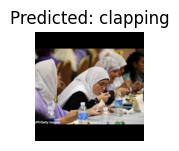

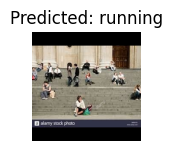

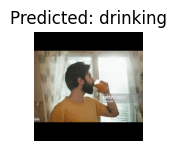

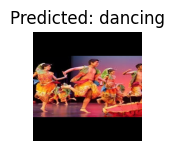

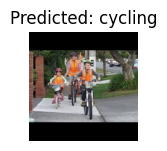

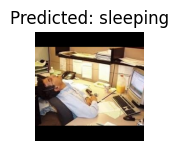

In [26]:
visualize_model(device, dataloaders, class_names, model_ft)

plt.ioff()
plt.show()

## Inference on custom images

tensor([[-5.5452, -3.4668, -6.0340, -4.6856, -4.2034, -6.0719, -3.4072, -1.1501,
         -2.9804, -3.0953, -5.3682, -4.6313,  0.3739, -2.6309, -4.3995]],
       device='cuda:0')
tensor([12], device='cuda:0')


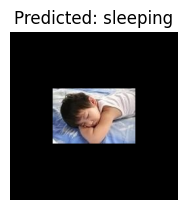

In [27]:
visualize_model_predictions(
    device,
    data_transform,
    class_names,
    model_ft,
    img=ds.dataset['image'][5]
)

plt.ioff()
plt.show()

In [28]:
ds.dataset['labels'][5]

12

## Save the model

In [29]:
torch.save(model_conv, 'models/model.pt')